In [1]:
library(xts);library(caret);library(dplyr);library(zoo)
library(tidyverse);library(lubridate);library(data.table)
library(ggplot2);library(timeDate);library(Metrics);
library(hydroGOF);library(imputeTS);library(readxl);library(forecastML)

Loading required package: zoo


Attaching package: ‘zoo’


The following objects are masked from ‘package:base’:

    as.Date, as.Date.numeric


Loading required package: lattice

Loading required package: ggplot2

Warning message in system("timedatectl", intern = TRUE):
“running command 'timedatectl' had status 1”

Attaching package: ‘dplyr’


The following objects are masked from ‘package:xts’:

    first, last


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


── Attaching packages ─────────────────────────────────────── tidyverse 1.3.0 ──

✔ tibble  3.1.0     ✔ purrr   0.3.4
✔ tidyr   1.1.3     ✔ stringr 1.4.0
✔ readr   1.4.0     ✔ forcats 0.5.1

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::first()  masks xts::first()
✖ dplyr::lag()    masks stats::lag()
✖ dplyr::last()   masks 

In [2]:
#df <- read.csv("2016_20_Anand_Vihar.csv", na.strings = "None")
## Data cleaning 
## Reading the excel file, starting with 12 line and giving NA as None
df <- read_xlsx('Data/Anand_Vihar_16_21.xlsx',skip = 12,na = "None")
## converting date into proper date format and selecting the relevant variable needed
df <- df %>% mutate(date = dmy_hm(`From Date`,tz="Asia/Kolkata"),PM25=`PM2.5`)%>%
select(date,PM25,AT,RH,WS,SR,WD)
head(df)

date,PM25,AT,RH,WS,SR,WD
<dttm>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
2016-01-01 01:00:00,376.00,11.43,69.00,0.30,12.25,216.25
2016-01-01 02:00:00,480.50,11.28,71.50,0.35,12.58,230.92
2016-01-01 03:00:00,486.67,11.71,71.83,0.31,12.33,203.25
2016-01-01 04:00:00,441.17,11.13,73.08,0.30,12.75,126.92
2016-01-01 05:00:00,594.83,11.01,74.75,0.30,12.58,196.42
2016-01-01 06:00:00,441.33,11.49,74.17,0.37,13.83,80.58


In [6]:
## Converting the data into daily time series
hourly_df <- df %>%
  select(date, PM25) %>% # to check the model for PM2.5 replace PM2.5 by PM2.5
  # extract date features
  mutate(
    date = as.POSIXct(date, format = "%d-%m-%Y %H:%M"), #Date format
    hour = hour(date),
    day = day(date),
    month = month(date),
    year = year(date),
    PM2.5 = ifelse(PM25 <10 | PM25 >999 ,NA,PM25)
  ) %>%
  # from hourly to daily
  group_by(date,hour, day, month, year) %>% ## Convert hourly to daily 
  summarise(PM25 = mean(PM2.5, na.rm = TRUE)) %>%
  mutate(week = week(date))

## Putting NA if there are null values 
hourly_df$PM25[is.nan(hourly_df$PM25)] <- NA
head(hourly_df)

`summarise()` has grouped output by 'date', 'hour', 'day', 'month'. You can override using the `.groups` argument.



date,hour,day,month,year,PM25,week
<dttm>,<int>,<int>,<int>,<int>,<dbl>,<int>
2016-01-01 01:00:00,1,1,1,2016,376.00,1
2016-01-01 02:00:00,2,1,1,2016,480.50,1
2016-01-01 03:00:00,3,1,1,2016,486.67,1
2016-01-01 04:00:00,4,1,1,2016,441.17,1
2016-01-01 05:00:00,5,1,1,2016,594.83,1
2016-01-01 06:00:00,6,1,1,2016,441.33,1


In [7]:
min(hourly_df$PM25,na.rm=T)

[1] 10

In [ ]:
######################## Seasonal Indexes #####################################

## We creating index of seasons from the data till 2020 end

seasonalIndex <- hourly_df %>% filter(date < as.Date("2021-1-01"))


############################### Hourly seasonality  #######################
hourly_s <- seasonalIndex %>% group_by(year, month, day,hour) %>%
  summarize(average = mean(PM25, na.rm = TRUE))

hourly_s$average[is.nan(hourly_s$average)] <- NA

## Spanning the year wise value column wise
hourly_s <- hourly_s %>% ungroup() %>%
  spread(year, average)
head(hourly_s)

# Calcuating the mean daily index over the years (Except first and second columns)
hourly_s$meanindex <- rowMeans(hourly_s[, -c(1,2,3)], na.rm = TRUE)

## Summary mean is the mean of Mean index
summary_mean <- hourly_s %>% ungroup() %>%
  summarize(summary_mean = mean(meanindex, na.rm = T))

## We merge the Summary mean with our old data frame 
hourly_s <- merge(hourly_s, summary_mean)

## Finally calculating the daily index by mean index/ summary mean * 100
hourly_s <-
  hourly_s %>% mutate(hourlyindex = meanindex / summary_mean * 100)

head(hourly_s)


`summarise()` has grouped output by 'year', 'month'. You can override using the `.groups` argument.



month,day,2016,2017,2018,2019,2020
<int>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,1,359.5730,199.8817,481.6250,380.2292,367.3750
1,2,327.9150,257.1204,359.6667,418.4688,361.6875
1,3,341.3188,271.6446,287.7083,412.8854,378.6765
1,4,480.0688,270.1217,351.6250,291.9479,216.5625
1,5,433.3537,246.8504,306.2500,241.6667,190.5938
1,6,371.7995,189.3525,324.7500,191.8542,166.8646


,month,day,2016,2017,2018,2019,2020,meanindex,summary_mean,dailyindex
,<int>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,1,1,359.5730,199.8817,481.6250,380.2292,367.3750,357.7368,138.1529,258.9426
2,1,2,327.9150,257.1204,359.6667,418.4688,361.6875,344.9717,138.1529,249.7028
3,1,3,341.3188,271.6446,287.7083,412.8854,378.6765,338.4467,138.1529,244.9798
4,1,4,480.0688,270.1217,351.6250,291.9479,216.5625,322.0652,138.1529,233.1222
5,1,5,433.3537,246.8504,306.2500,241.6667,190.5938,283.7429,138.1529,205.3832
6,1,6,371.7995,189.3525,324.7500,191.8542,166.8646,248.9242,138.1529,180.1802


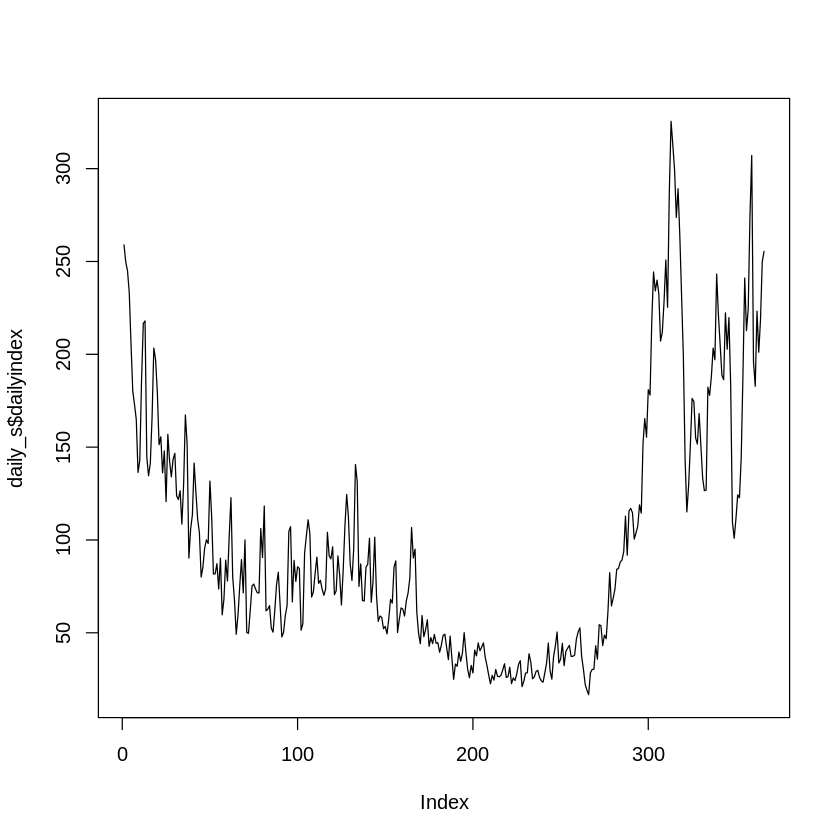

In [5]:
############################### daily seasonality  #######################
daily_s <- seasonalIndex %>% group_by(year, month, day) %>%
  summarize(average = mean(PM25, na.rm = TRUE))

daily_s$average[is.nan(daily_s$average)] <- NA

## Spanning the year wise value column wise
daily_s <- daily_s %>% ungroup() %>%
  spread(year, average)
head(daily_s)

# Calcuating the mean daily index over the years (Except first and second columns)
daily_s$meanindex <- rowMeans(daily_s[, -c(1,2)], na.rm = TRUE)

## Summary mean is the mean of Mean index
summary_mean <- daily_s %>% ungroup() %>%
  summarize(summary_mean = mean(meanindex, na.rm = T))

## We merge the Summary mean with our old data frame 
daily_s <- merge(daily_s, summary_mean)

## Finally calculating the daily index by mean index/ summary mean * 100
daily_s <-
  daily_s %>% mutate(dailyindex = meanindex / summary_mean * 100)

head(daily_s)
plot(daily_s$dailyindex,type="l")

`summarise()` has grouped output by 'year'. You can override using the `.groups` argument.



week,2016,2017,2018,2019,2020
<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,386.0533,239.1619,351.9375,322.8420,278.9070
2,348.5349,169.6000,267.3865,259.8899,179.3212
3,250.1298,162.1944,298.8579,283.6310,148.1811
4,324.5103,165.4973,185.1027,118.1771,200.7925
5,348.7608,178.0511,169.1964,189.1205,109.1730
6,208.5622,151.1387,193.1677,157.0849,157.4178


,week,2016,2017,2018,2019,2020,meanindex,summary_mean,weeklyindex
,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,1,386.0533,239.1619,351.9375,322.8420,278.9070,315.7803,142.6411,221.3811
2,2,348.5349,169.6000,267.3865,259.8899,179.3212,244.9465,142.6411,171.7223
3,3,250.1298,162.1944,298.8579,283.6310,148.1811,228.5988,142.6411,160.2616
4,4,324.5103,165.4973,185.1027,118.1771,200.7925,198.8160,142.6411,139.3820
5,5,348.7608,178.0511,169.1964,189.1205,109.1730,198.8604,142.6411,139.4131
6,6,208.5622,151.1387,193.1677,157.0849,157.4178,173.4742,142.6411,121.6159


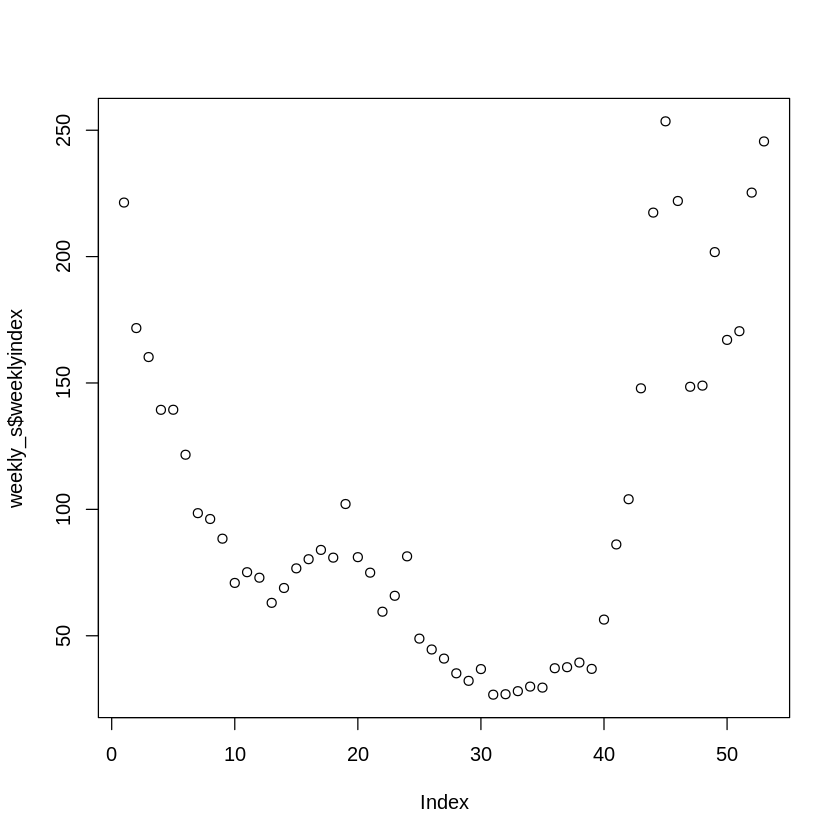

In [6]:
############################### weekly seasonality ###########
weekly_s <- seasonalIndex %>%
  group_by(year, week) %>%
  summarize(average = mean(PM25, na.rm = TRUE))

## NA if the average in null
weekly_s$average[is.nan(weekly_s$average)] <- NA

## Spreading across weeks
weekly_s <- weekly_s %>% ungroup() %>%
  spread(year, average)

head(weekly_s)

# Calcuating the mean weekly index over the years
weekly_s$meanindex <- rowMeans(weekly_s[, -1], na.rm = TRUE)

## Calculting summary means
summary_mean <- weekly_s %>% ungroup() %>%
  summarize(summary_mean = mean(meanindex, na.rm = T))

## Adding summary mean
weekly_s <- merge(weekly_s, summary_mean)

## Calculating weekly index
weekly_s <-
  weekly_s %>% mutate(weeklyindex = meanindex / summary_mean * 100)

head(weekly_s)
plot(weekly_s$weeklyindex)

`summarise()` has grouped output by 'year'. You can override using the `.groups` argument.



month,2016,2017,2018,2019,2020
<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,328.74805,182.1364,263.5642,235.80948,183.39218
2,173.26539,140.3369,161.1128,140.30696,124.65472
3,117.04639,112.5573,120.0038,101.89716,64.33173
4,156.06138,129.8789,116.7254,97.78571,47.21875
5,99.84961,150.9615,106.2613,110.90099,72.89104
6,93.00049,102.5391,115.4411,73.47958,64.95588


,month,2016,2017,2018,2019,2020,meanindex,summary_mean,monthlyindex
,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,1,328.74805,182.1364,263.5642,235.80948,183.39218,238.73007,140.5524,169.85127
2,2,173.26539,140.3369,161.1128,140.30696,124.65472,147.93535,140.5524,105.25280
3,3,117.04639,112.5573,120.0038,101.89716,64.33173,103.16728,140.5524,73.40128
4,4,156.06138,129.8789,116.7254,97.78571,47.21875,109.53402,140.5524,77.93108
5,5,99.84961,150.9615,106.2613,110.90099,72.89104,108.17290,140.5524,76.96267
6,6,93.00049,102.5391,115.4411,73.47958,64.95588,89.88322,140.5524,63.94996


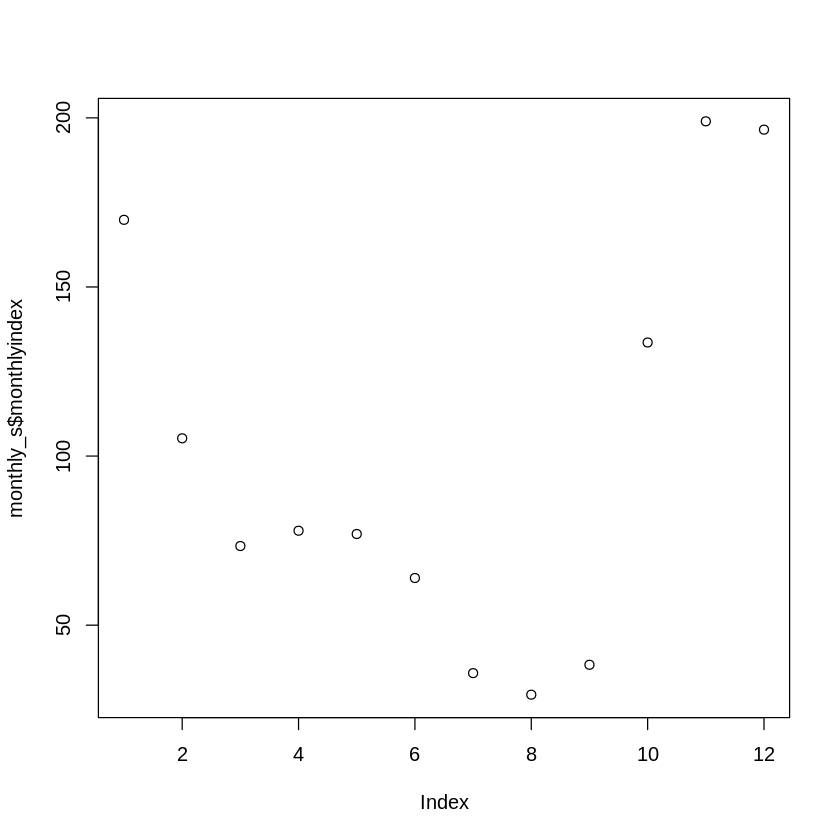

In [7]:
############################### monthly seasonality ##############################

## Grouping by year and month
monthly_s <- seasonalIndex %>%
  group_by(year, month) %>%
  summarize(average = mean(PM25, na.rm = TRUE))

## Adding NA values if there are any null values of any sort 
monthly_s$average[is.nan(monthly_s$average)] <- NA

## Spreading across months 
monthly_s <- monthly_s %>% ungroup() %>%
  spread(year, average)

head(monthly_s)

# Calcuating the mean weekly index over the years (-1 to remove first column which is month)
monthly_s$meanindex <- rowMeans(monthly_s[, -1], na.rm = TRUE)

## Summary mean of the mean index
summary_mean <- monthly_s %>% ungroup() %>%
  summarize(summary_mean = mean(meanindex, na.rm = T))

## Merging the summary mean with the data frame
monthly_s <- merge(monthly_s, summary_mean)

## Adding the Monthly index
monthly_s <-
  monthly_s %>% mutate(monthlyindex = meanindex / summary_mean * 100)
head(monthly_s)
plot(monthly_s$monthlyindex)

In [8]:
############# Join the indexes to original houly data

hourly_s <- hourly_s %>% select(month,day,hour,hourlyindex)
hourly_df <- hourly_df %>% left_join(hourly_s,by=c("month","day","hour"))

daily_s <- daily_s %>% select(month, day, dailyindex)
hourly_df <- hourly_df %>% left_join(daily_s, by = c("month", "day"))

monthly_s <- monthly_s %>% select(month, monthlyindex)
hourly_df <- hourly_df %>% left_join(monthly_s, by = c("month"))

weekly_s <- weekly_s %>% select(week, weeklyindex)
hourly_df <- hourly_df %>% left_join(weekly_s, by = c("week"))

head(hourly_df)
## Removing the unnecessary data frames 
rm(hourly_s)
rm(daily_s)
rm(monthly_s)
rm(weekly_s)
rm(summary_mean)
rm(seasonalIndex)


date,hour,day,month,year,PM25,week,hourlyindex,dailyindex,monthlyindex,weeklyindex
<dttm>,<int>,<int>,<int>,<int>,<dbl>,<int>,<dbl>,<dbl>,<dbl>,<dbl>
2016-01-01 01:00:00,1,1,1,2016,376.00,1,332.0040,258.9426,169.8513,221.3811
2016-01-01 02:00:00,2,1,1,2016,480.50,1,354.0614,258.9426,169.8513,221.3811
2016-01-01 03:00:00,3,1,1,2016,486.67,1,342.7143,258.9426,169.8513,221.3811
2016-01-01 04:00:00,4,1,1,2016,441.17,1,309.5135,258.9426,169.8513,221.3811
2016-01-01 05:00:00,5,1,1,2016,594.83,1,322.8215,258.9426,169.8513,221.3811
2016-01-01 06:00:00,6,1,1,2016,441.33,1,250.7651,258.9426,169.8513,221.3811


In [9]:
################### Data manipulation using forecastML
## Fill_gaps is a function from forecatML to see if there are missing value it creates
## an evenly spaced data frame
hourly_ts <- fill_gaps(hourly_df, date_col = 1, frequency = "1 hour")
dates <- hourly_ts$date

#hourly_ts$date <- NULL
hourly_ts$hour <- NULL
hourly_ts$day <- NULL
hourly_ts$month <- NULL
hourly_ts$week <- NULL
head(hourly_ts)


,date,year,PM25,hourlyindex,dailyindex,monthlyindex,weeklyindex
,<dttm>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,2016-01-01 01:00:00,2016,376.00,332.0040,258.9426,169.8513,221.3811
2,2016-01-01 02:00:00,2016,480.50,354.0614,258.9426,169.8513,221.3811
3,2016-01-01 03:00:00,2016,486.67,342.7143,258.9426,169.8513,221.3811
4,2016-01-01 04:00:00,2016,441.17,309.5135,258.9426,169.8513,221.3811
5,2016-01-01 05:00:00,2016,594.83,322.8215,258.9426,169.8513,221.3811
6,2016-01-01 06:00:00,2016,441.33,250.7651,258.9426,169.8513,221.3811


In [10]:
hourly_ts_filtered <- hourly_ts %>% filter(date>=ymd("2020-01-01"))%>% mutate(PM25=ifelse(is.na(PM25), median(PM25, na.rm = T), PM25))
head(hourly_ts_filtered)

,date,year,PM25,hourlyindex,dailyindex,monthlyindex,weeklyindex
,<dttm>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,2020-01-01 00:00:00,2020,857.50,413.4852,258.9426,169.8513,221.3811
2,2020-01-01 01:00:00,2020,472.75,332.0040,258.9426,169.8513,221.3811
3,2020-01-01 02:00:00,2020,384.75,354.0614,258.9426,169.8513,221.3811
4,2020-01-01 03:00:00,2020,334.50,342.7143,258.9426,169.8513,221.3811
5,2020-01-01 04:00:00,2020,362.75,309.5135,258.9426,169.8513,221.3811
6,2020-01-01 05:00:00,2020,403.25,322.8215,258.9426,169.8513,221.3811


In [11]:
data_train <- hourly_ts_filtered %>% filter(date <ymd('2021-01-01'))
data_test <- hourly_ts_filtered %>% filter(date >ymd('2021-01-01'))
head(data_test)

,date,year,PM25,hourlyindex,dailyindex,monthlyindex,weeklyindex
,<dttm>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,2021-01-01 01:00:00,2021,87,332.0040,258.9426,169.8513,221.3811
2,2021-01-01 02:00:00,2021,87,354.0614,258.9426,169.8513,221.3811
3,2021-01-01 03:00:00,2021,87,342.7143,258.9426,169.8513,221.3811
4,2021-01-01 04:00:00,2021,87,309.5135,258.9426,169.8513,221.3811
5,2021-01-01 05:00:00,2021,87,322.8215,258.9426,169.8513,221.3811
6,2021-01-01 06:00:00,2021,87,250.7651,258.9426,169.8513,221.3811


In [13]:
## Now creating a training data frame with lookback of 12 hours 
data_train_lagged <-
  create_lagged_df(
    data_train, ## data frame
    type = "train", ## training 
    outcome_col = 3,## Output column is PM2.5 
    horizons = 1, ## Horizons is used if you want to predict for more than one hour
    lookback = c(1:12),## Lookback of 12 hour
    dynamic_features = c("year","hourlyindex","hour", "dailyindex", "monthlyindex", "weeklyindex","date"), ## dynamic features of index
    frequency = "1 hour" ## Frequency is 1 day
  )

## Now creating a training data frame with lookback of 7 days 
data_test_lagged <-
  create_lagged_df(
    data_test, ## data frame
    type = "train", ## training 
    outcome_col = 3,## Output column is PM2.5 
    horizons = 1, ## Horizons is used if you want to use different models in different time frames
    lookback = c(1:12),## Lookback of 12 hour
    dynamic_features = c("year","hourlyindex","hour", "dailyindex", "monthlyindex", "weeklyindex","date"), ## dynamic features of index
    frequency = "1 hour" ## Frequency is 1 day
  )


## Looking at the first horizon data frame
data_train_lagged <- data_train_lagged$horizon_1
data_test_lagged <- data_test_lagged$horizon_1
head(data_train_lagged)

,PM25,PM25_lag_1,PM25_lag_2,PM25_lag_3,PM25_lag_4,PM25_lag_5,PM25_lag_6,PM25_lag_7,PM25_lag_8,PM25_lag_9,PM25_lag_10,PM25_lag_11,PM25_lag_12,date,year,hourlyindex,dailyindex,monthlyindex,weeklyindex
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dttm>,<int>,<dbl>,<dbl>,<dbl>,<dbl>
13,187.75,247.50,338.75,420.25,447.25,420.00,396.50,403.25,362.75,334.50,384.75,472.75,857.50,2020-01-01 12:00:00,2020,224.38866,258.9426,169.8513,221.3811
14,143.75,187.75,247.50,338.75,420.25,447.25,420.00,396.50,403.25,362.75,334.50,384.75,472.75,2020-01-01 13:00:00,2020,191.81453,258.9426,169.8513,221.3811
15,133.00,143.75,187.75,247.50,338.75,420.25,447.25,420.00,396.50,403.25,362.75,334.50,384.75,2020-01-01 14:00:00,2020,162.07933,258.9426,169.8513,221.3811
16,131.00,133.00,143.75,187.75,247.50,338.75,420.25,447.25,420.00,396.50,403.25,362.75,334.50,2020-01-01 15:00:00,2020,115.22099,258.9426,169.8513,221.3811
17,101.50,131.00,133.00,143.75,187.75,247.50,338.75,420.25,447.25,420.00,396.50,403.25,362.75,2020-01-01 16:00:00,2020,95.08851,258.9426,169.8513,221.3811
18,88.00,101.50,131.00,133.00,143.75,187.75,247.50,338.75,420.25,447.25,420.00,396.50,403.25,2020-01-01 17:00:00,2020,106.08758,258.9426,169.8513,221.3811


In [14]:
dep_variable <- "PM25"
ind_variables <- setdiff(names(data_train_lagged),c("date","year","PM25"))
formulae <- as.formula(paste(dep_variable,paste(ind_variables,collapse="+"),sep=" ~ "))
formulae

PM25 ~ PM25_lag_1 + PM25_lag_2 + PM25_lag_3 + PM25_lag_4 + PM25_lag_5 + 
    PM25_lag_6 + PM25_lag_7 + PM25_lag_8 + PM25_lag_9 + PM25_lag_10 + 
    PM25_lag_11 + PM25_lag_12 + hourlyindex + dailyindex + monthlyindex + 
    weeklyindex

In [15]:
tc <- trainControl(method="cv", number = 10)
lm1_cv <- train(formulae, method="lm",
                   data = data_train_lagged,trControl=tc)
lm1_cv

Linear Regression 

8772 samples
  16 predictor

No pre-processing
Resampling: Cross-Validated (10 fold) 
Summary of sample sizes: 7896, 7894, 7894, 7896, 7894, 7895, ... 
Resampling results:

  RMSE      Rsquared   MAE     
  33.18281  0.9033854  15.29329

Tuning parameter 'intercept' was held constant at a value of TRUE

In [16]:
start <- Sys.time()
rf1_cv <- train(formulae, method="rf",
                   data = data_train_lagged,trControl=tc)
rf1_cv

Random Forest 

8772 samples
  16 predictor

No pre-processing
Resampling: Cross-Validated (10 fold) 
Summary of sample sizes: 7895, 7894, 7895, 7894, 7895, 7896, ... 
Resampling results across tuning parameters:

  mtry  RMSE      Rsquared  MAE     
   2    34.22641  0.901938  16.15692
   9    31.41055  0.915055  13.80473
  16    32.04121  0.911320  13.96325

RMSE was used to select the optimal model using the smallest value.
The final value used for the model was mtry = 9.

In [17]:
end <- Sys.time()
end-start

Time difference of 31.58023 mins

In [ ]:
summary(lm1_cv)

In [12]:
pred_lm <- predict(lmq_cv, data_test_lagged)
R2(data_test_lagged$PM25,pred_lm)
MAE(data_test_lagged$PM25,pred_lm)
RMSE(data_test_lagged$PM25,pred_lm)

[1] 0.8265894

[1] 26.41404

[1] 49.74382

In [11]:

#save.image(file = "Model_output/Forecasting_Index_1year.RData") 